In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.artifacts.video_artifact import VideoArtifact
import torch

torch.set_grad_enabled(False)

extr_anim_art = AnimationArtifact.from_wandb_artifact_tag('extr_anim:latest')
extr_ims_art = VideoArtifact.from_wandb_artifact_tag('extr_images:latest')

In [2]:
extr_ims = extr_ims_art.read_frames()
extr_seq = extr_anim_art.read_anim_seq()

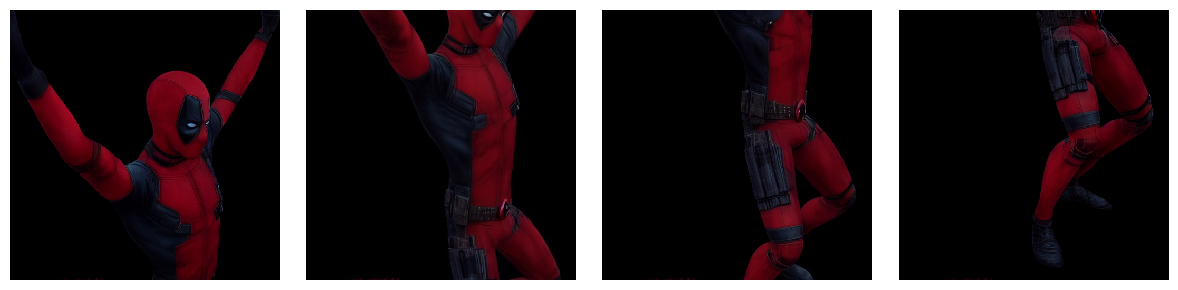

In [22]:
from text3d2video.utilities.ipython_utils import display_ims


display_ims(extr_ims)

In [23]:
from text3d2video.pipelines.generative_rendering_pipeline import RgbExtractionPipeline
from text3d2video.pipelines.pipeline_utils import load_pipeline

pipe = load_pipeline(RgbExtractionPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


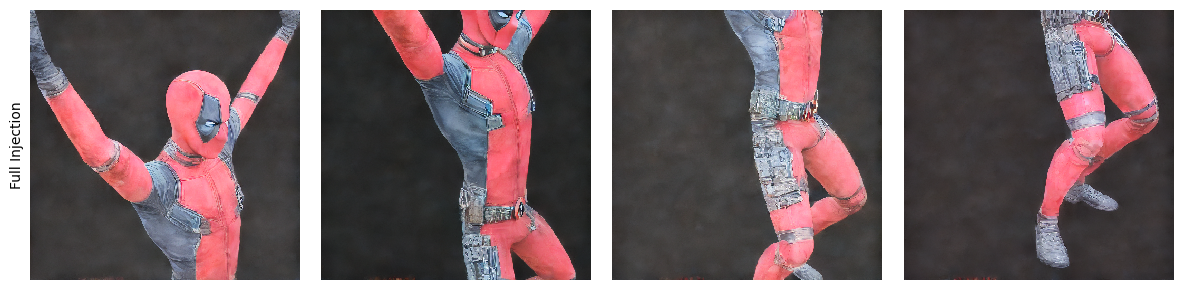

In [24]:
from text3d2video.utilities.ipython_utils import display_ims

gen = torch.Generator(device="cuda").manual_seed(0)

images = pipe("Deadpool", extr_seq, extr_ims, generator=gen)

display_ims(images, row_title="Full Injection")

In [17]:
from text3d2video.utilities.video_comparison import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip


display_vid(pil_frames_to_clip(images))

In [22]:
timesteps = pipe.get_partial_timesteps(10, 0)
t = timesteps[0]

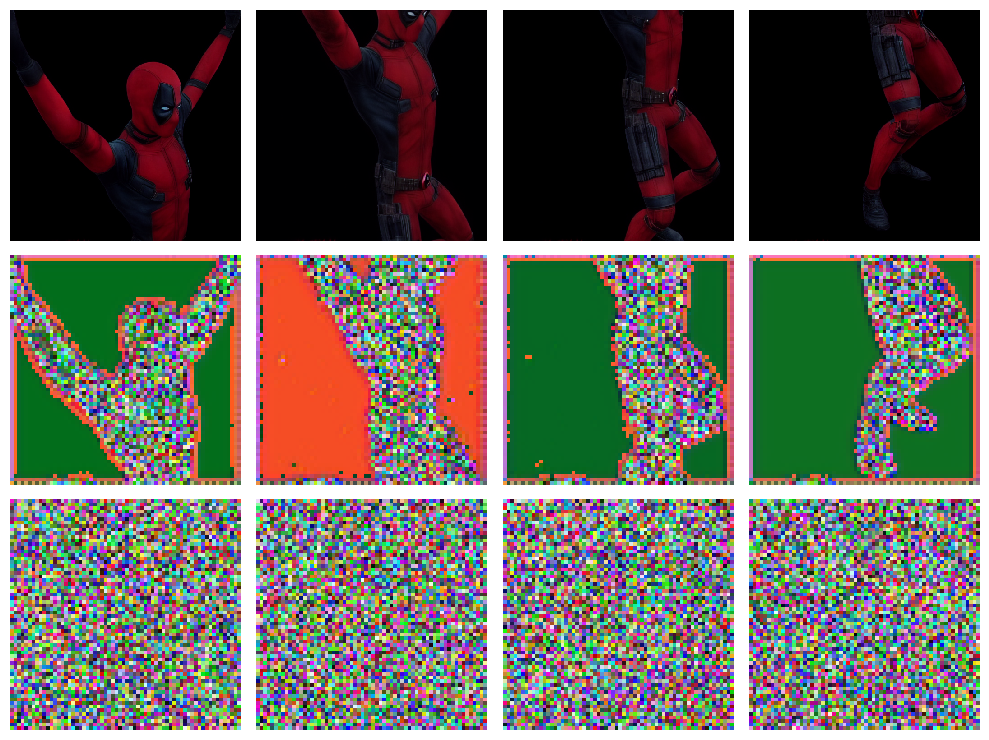

In [23]:
from text3d2video.util import pil_latent
from text3d2video.utilities.ipython_utils import display_ims, display_ims_grid


latents = pipe.encode_images(extr_ims)

noise = torch.randn_like(latents)
noisy = pipe.scheduler.add_noise(latents, noise, t)

display_ims_grid(
    [extr_ims, [pil_latent(x) for x in latents], [pil_latent(x) for x in noisy]]
)

In [24]:
from text3d2video.pipelines.generative_rendering_pipeline import GenerativeRenderingLogic

module_paths = [
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr = GenerativeRenderingLogic(pipe, module_paths)

In [25]:
gr.set_attn_processor()

prompt = "Deadpool"
cond_embs, uncond_embs = pipe.encode_prompt([prompt] * len(latents))
depths = extr_seq.render_depth_maps()

model_out = gr.model_forward_extraction(noisy, cond_embs, uncond_embs, depths, t)

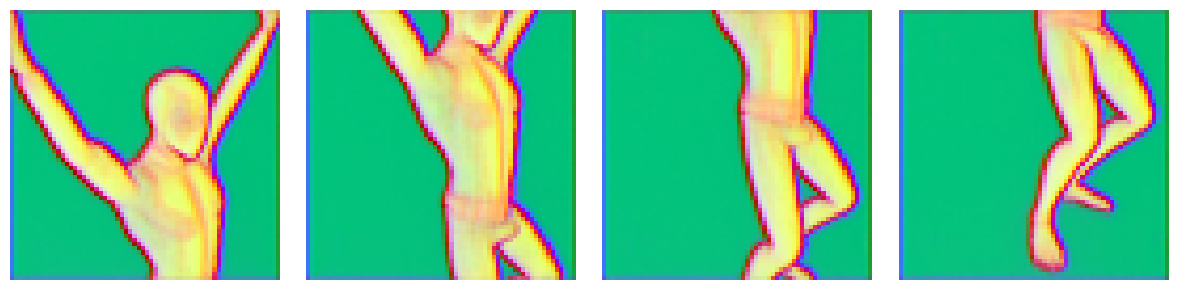

In [26]:
from einops import rearrange
from text3d2video.feature_visualization import RgbPcaUtil


post_attns = model_out.cond_post_attn

layer = module_paths[7]

post_attn = post_attns[layer].cpu()

post_attn_flat = rearrange(post_attn, 'b c h w -> (h w b) c')

pca = RgbPcaUtil.init_from_features(post_attn_flat)

display_ims([pca.feature_map_to_rgb_pil(x) for x in post_attn])